# The Nature Conservancy Fisheries Monitoring

## Imports, globals etc

In [1]:
%matplotlib inline

In [2]:
from vgg16 import Vgg16
from utils import *

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1070 (CNMeM is disabled, cuDNN 5110)


In [3]:
from keras.optimizers import Adadelta, Nadam

In [4]:
DATA_DIR = '/home/akir/nbs/data/fisheries/'
SAMPLE_DIR = '/home/akir/nbs/sample/fisheries/'
MODEL_DIR = '/home/akir/nbs/data/models/fisheries/'

classes = [
    'ALB',
    'BET',
    'DOL',
    'LAG',
    'NoF',
    'OTHER',
    'SHARK',
    'YFT'
]

#DIR = SAMPLE_DIR
DIR = DATA_DIR

batch_size = 48

## Create validation, sample and test sets

In [6]:
import os
    
if not os.path.exists(DATA_DIR + 'test/unknown'):
    os.makedirs(DATA_DIR + 'test/unknown')

if not os.path.exists(SAMPLE_DIR + 'test/unknown'):
    os.makedirs(SAMPLE_DIR + 'test/unknown')

directories = [
    DATA_DIR + 'valid',
    SAMPLE_DIR + 'valid',
    SAMPLE_DIR + 'train'
]

for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)
    for c in classes:
        new_dir = '{}/{}'.format(directory, c)
        if not os.path.exists(new_dir):
            os.mkdir(new_dir)

## Arrange images into their respective directories

In [7]:
# move test data to correct directory
%mv $DATA_DIR/test_stg1/*.jpg $DATA_DIR/test/unknown
%rmdir $DATA_DIR/test_stg1

In [10]:
# move validation data to correct directory
import shutil

# add additional random data to validation set
valid_pct = 0.15

for c in classes:
    g = glob(DATA_DIR + 'train/' + c + '/*.jpg')
    shuf = np.random.permutation(g)
    n = int(valid_pct * len(shuf))
    for i in range(n):
        shutil.move(shuf[i], DATA_DIR + '/valid/' + c);


In [7]:
# create sample set
from shutil import copy

sample_pct = 0.1

# test
g = glob(DATA_DIR + '/test/unknown/*.jpg')
shuf = np.random.permutation(g)
num = int(len(shuf) * sample_pct)
for i in range(num):
    copy(shuf[i], SAMPLE_DIR + '/test/unknown')

for c in classes:
    g = glob(DATA_DIR + '/train/' + c + '/*.jpg')
    shuf = np.random.permutation(g)
    num = int(len(shuf) * sample_pct)
    for i in range(num):
        copy(shuf[i], SAMPLE_DIR + '/train/' + c)
    
# valid
for c in classes:
    g = glob(DATA_DIR + '/valid/' + c + '/*.jpg')
    shuf = np.random.permutation(g)
    num = int(len(shuf) * sample_pct)
    for i in range(num):
        copy(shuf[i], SAMPLE_DIR + '/valid/' + c)


## Get batches

In [5]:
#gen = image.ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
#                                shear_range=0.05, zoom_range=0.1, horizontal_flip=True, channel_shift_range=0.05)
gen = image.ImageDataGenerator()
#batches = get_batches(DIR + 'train', batch_size=batch_size, gen=gen, shuffle=True)
batches = get_batches(DIR + 'train', batch_size=batch_size, gen=gen, shuffle=False)
val_batches = get_batches(DIR + 'valid', batch_size=batch_size*2, shuffle=False)

Found 3393 images belonging to 8 classes.
Found 384 images belonging to 8 classes.


In [6]:
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames,
    test_filenames) = get_classes(DIR)

Found 3393 images belonging to 8 classes.
Found 384 images belonging to 8 classes.
Found 12153 images belonging to 1 classes.


## Basic models

### Linear model

In [7]:
# kaggle score: 1.81806
model = Sequential()
model.add(BatchNormalization(axis=1, input_shape=(3,224,224)))
model.add(Flatten())
model.add(Dense(8, activation='softmax'))

In [8]:
lr = 0.0001
optimizer = Adam(lr=lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=1, validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
3393/3393 [==============================] - 71s - loss: 1.8145 - acc: 0.6552 - val_loss: 3.1767 - val_acc: 0.5078


In [14]:
model.optimizer.lr = 0.01
model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/2
3025/3025 [==============================] - 89s - loss: 0.5014 - acc: 0.8674 - val_loss: 0.8305 - val_acc: 0.8378
Epoch 2/2
3025/3025 [==============================] - 76s - loss: 0.3530 - acc: 0.9051 - val_loss: 0.7347 - val_acc: 0.8511


### Single hidden layer

In [13]:
# kaggle score: 1.28137
model = Sequential()
model.add(BatchNormalization(axis=1, input_shape=(3,224,224)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='softmax'))
          
lr = 0.0001
optimizer = Adam(lr=lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=1, validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
3025/3025 [==============================] - 99s - loss: 1.3995 - acc: 0.6238 - val_loss: 3.4336 - val_acc: 0.4242

In [15]:
model.optimizer.lr = 0.01
model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/2
3025/3025 [==============================] - 93s - loss: 0.6462 - acc: 0.8562 - val_loss: 0.8020 - val_acc: 0.7846

### Pre-trained VGG16

In [7]:
# kaggle score: 1.06

# create vgg16 model
vgg = Vgg16()

# get convutional part from model
conv_layers = vgg.model.layers[:-7]

# create new model from convolutional parts
conv_model = Sequential(conv_layers)


/home/akir/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/akir/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/akir/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


In [8]:
# get batches without shuffle since we are pre-computing
batches = get_batches(DIR + 'train', batch_size=batch_size, shuffle=False)

# precompute train predictions
conv_feat = conv_model.predict_generator(batches, batches.nb_sample)

Found 3393 images belonging to 8 classes.


In [9]:
# precompute validation predictions
conv_val_feat = conv_model.predict_generator(val_batches, val_batches.nb_sample)

In [10]:
# precompute test predictions
test_batches = get_batches(DIR + 'test', batch_size=batch_size*2, shuffle=False, class_mode=None)
conv_test_feat = conv_model.predict_generator(test_batches, test_batches.nb_sample)

Found 12153 images belonging to 1 classes.


In [11]:
save_array(MODEL_DIR + 'conv_feat.dat', conv_feat)
save_array(MODEL_DIR + 'conv_val_feat.dat', conv_val_feat)

In [12]:
save_array(MODEL_DIR + 'conv_test_feat_stage2.dat', conv_test_feat)

In [ ]:
conv_feat = load_array(MODEL_DIR + 'conv_feat.dat')
conv_val_feat = load_array(MODEL_DIR + 'conv_val_feat.dat')

In [30]:
conv_test_feat = load_array(MODEL_DIR + 'conv_test_feat_stage2.dat')

In [13]:
print conv_feat.shape
print conv_val_feat.shape

(3393, 512, 14, 14)
(384, 512, 14, 14)


In [14]:
conv_test_feat.shape

(12153, 512, 14, 14)

In [13]:
conv_layers[-1].output_shape[1:]

(512, 14, 14)

### Pre-trained VGG16 with data augmentation

In [23]:
# create vgg16 model
vgg = Vgg16()

# get convutional part from model
conv_layers = vgg.model.layers[:-7]

# create new model from convolutional parts
conv_model = Sequential(conv_layers)


In [24]:
conv_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 3, 224, 224)   0           lambda_input_4[0][0]             
____________________________________________________________________________________________________
zeropadding2d_40 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_4[0][0]                   
                                                                   lambda_4[0][0]                   
____________________________________________________________________________________________________
convolution2d_40 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_40[0][0]           
                                                                   zeropadding2d_40[1][0]           
___________________________________________________________________________________________

In [25]:
# get batches without shuffle since we are pre-computing
gen = image.ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                                shear_range=0.05, zoom_range=0.1, horizontal_flip=True, channel_shift_range=0.05)
batches = get_batches(DIR + 'train', batch_size=batch_size, gen=gen, shuffle=False)

# precompute train predictions
da_conv_feat = conv_model.predict_generator(batches, batches.nb_sample * 5)

Found 3393 images belonging to 8 classes.


In [27]:
da_conv_feat.shape

(16965, 512, 14, 14)

In [26]:
save_array(MODEL_DIR + 'da_conv_feat.dat', da_conv_feat)

In [45]:
da_conv_feat = load_array(MODEL_DIR + 'da_conv_feat.dat')

In [28]:
conv_val_feat = load_array(MODEL_DIR + 'conv_val_feat.dat')

In [11]:
conv_layers[-1].output_shape

(None, 25088)

In [29]:
da_trn_labels = np.concatenate([trn_labels]*5)

In [22]:
da_conv_feat.shape

(16965, 25088)

In [37]:
conv_test_feat = load_array(MODEL_DIR + 'conv_test_feat.dat')

#### Use precomputed data with 1 layer model

In [30]:
# kaggle score: 1.14401
model = Sequential()

# start with batch normalization
model.add(BatchNormalization(input_shape=conv_layers[-1].output_shape[1:], axis=1))

# let's put back the max pooling and flatten
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())

# first dense layer
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# second dense layer
#model.add(Dense(100, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.4))

# output layer
model.add(Dense(8, activation='softmax'))

In [17]:
# compile model
lr = 0.0001
optimizer = Adam(lr=lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# first iteration with low learning rate
model.optimizer.lr = 0.0001
#model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=1, validation_data=(conv_val_feat, val_labels))
model.fit(da_conv_feat, da_trn_labels, batch_size=batch_size, nb_epoch=1, validation_data=(conv_val_feat, val_labels))

Exception: Error when checking model input: expected lambda_input_1 to have shape (None, 3, 224, 224) but got array with shape (3393, 512, 14, 14)

In [33]:
model.save_weights(MODEL_DIR + 'vgg-da-ft1.h5')

In [35]:
# raise learning rate a bit and continue training
model.optimizer.lr = 0.01
#model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=1, validation_data=(conv_val_feat, val_labels))
model.fit(da_conv_feat, da_trn_labels, batch_size=batch_size, nb_epoch=1, validation_data=(conv_val_feat, val_labels))

Train on 16965 samples, validate on 384 samples
Epoch 1/1
16965/16965 [==============================] - 110s - loss: 0.4855 - acc: 0.8624 - val_loss: 0.4792 - val_acc: 0.8776

In [36]:
model.save_weights(MODEL_DIR + 'vgg-da-ft2.h5') # 0.47/0.87

In [46]:
# looking good, let's check if it still improves
model.optimizer.lr = 0.01
#model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=4, validation_data=(conv_val_feat, val_labels))
model.fit(da_conv_feat, da_trn_labels, batch_size=batch_size, nb_epoch=4, validation_data=(conv_val_feat, val_labels))

Train on 16965 samples, validate on 384 samples
Epoch 1/4
16965/16965 [==============================] - 110s - loss: 0.2669 - acc: 0.9342 - val_loss: 0.4373 - val_acc: 0.8854

In [47]:
model.save_weights(MODEL_DIR + 'vgg-da-ft2.h5') # 0.34/0.92

In [19]:
model.save_weights(MODEL_DIR + 'vgg-1-dense-ft4.h5')

In [8]:
model.load_weights(MODEL_DIR + 'vgg-1-dense-ft4.h5')

### Finetuned VGG16

In [7]:
vgg = Vgg16()
model = vgg.model

In [20]:
model.layers[:-7]

In [8]:
# kaggle score: 1.18220
# finetune output layer and re-train dense layers

# remove output layer
model.pop()

# set convolution layers as non trainable
for layer in model.layers[:-7]: # re-train two dense layers
#for layer in model.layers: # re-train only convolutional layers
#for layer in model.layers[:-4]: # re-rain one dense layer
    layer.trainable = False;

# new output layer
model.add(Dense(8, activation='softmax'))

In [9]:
lr = 0.0001
#optimizer = Adam(lr=lr)
optimizer = Adadelta()
#optimizer = Nadam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
model.load_weights(MODEL_DIR + 'vgg-retrain-ft2.h5')

#### Train model

In [10]:
# start with low learning rate
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
3248/3248 [==============================] - 69s - loss: 1.4403 - acc: 0.6644 - val_loss: 0.4628 - val_acc: 0.8601

In [11]:
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
3248/3248 [==============================] - 70s - loss: 0.1412 - acc: 0.9584 - val_loss: 0.1762 - val_acc: 0.9679

In [12]:
# start with low learning rate
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
3248/3248 [==============================] - 70s - loss: 0.0483 - acc: 0.9861 - val_loss: 0.2395 - val_acc: 0.9471

In [13]:
# looking good, lower learning rate as it's almost learnt
model.optimizer.lr = 0.0001
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
 512/3248 [===>..........................] - ETA: 53s - loss: 9.1609 - acc: 0.4316

KeyboardInterrupt: 

In [25]:
model.save_weights(MODEL_DIR + 'vgg-retrain-ft1.h5')

In [30]:
model.load_weights(MODEL_DIR + 'vgg-bn-retrain-ft1.h5')

In [18]:
# looking good, increase learning rate and train more
model.optimizer.lr = 0.001
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
3383/3383 [==============================] - 114s - loss: 2.2407 - acc: 0.7248 - val_loss: 2.1130 - val_acc: 0.7614

In [ ]:
# looking good, increase learning train more
#model.optimizer.lr = 0.01
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
3319/3383 [============================>.] - ETA: 1s - loss: 1.8121 - acc: 0.7659  

In [55]:
model.save_weights(MODEL_DIR + 'vgg-bn-retrain-ft2.h5')

In [56]:
# still looking good! Train more
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
3393/3393 [==============================] - 115s - loss: 1.4490 - acc: 0.7801 - val_loss: 2.1040 - val_acc: 0.7240

In [57]:
model.save_weights(MODEL_DIR + 'vgg-bn-retrain-ft3.h5')

In [11]:
model.load_weights(MODEL_DIR + 'vgg-retrain-ft11.h5')

Exception: You are trying to load a weight file containing 16 layers into a model with 18 layers.

In [64]:
# looking good, increase learning rate and train more
#model.optimizer.lr = 0.00001
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
2718/2782 [============================>.] - ETA: 1s - loss: 4.1654 - acc: 0.4099  

KeyboardInterrupt: 

In [ ]:
model.save_weights(MODEL_DIR + 'vgg-retrain-ft3.h5')

### Re-trained VG16 with Batch normalization

In [12]:
vgg = Vgg16()
model = vgg.model

In [13]:
# remove output and two dense layers + flatten
for i in range(6):
    model.pop()
    
# do not re-train any of the layers
for layer in model.layers:
    layer.trainable = False

In [14]:
p = 0.0
model.add(BatchNormalization(axis=1))
model.add(Flatten())

model.add(Dense(1512))
model.add(BatchNormalization())
model.add(Dropout(p))

model.add(Dense(1512))
model.add(BatchNormalization())
model.add(Dropout(p))

model.add(Dense(8, activation='softmax'))

In [15]:
lr = 0.0001
optimizer = Adam(lr=lr)
#optimizer = Adadelta()
#optimizer = Nadam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# start with low learning rate
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
3393/3393 [==============================] - 70s - loss: 1.0087 - acc: 0.8176 - val_loss: 0.3768 - val_acc: 0.9401

In [18]:
# looking good, train some more
model.optimizer.lr = 0.00001
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
3393/3393 [==============================] - 71s - loss: 0.1875 - acc: 0.9761 - val_loss: 0.1837 - val_acc: 0.9609

In [20]:
# looking good, train some more
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
3393/3393 [==============================] - 70s - loss: 0.2168 - acc: 0.9702 - val_loss: 0.4507 - val_acc: 0.9375

In [21]:
# looking good, train some more
model.optimizer.lr = 0.00001
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
3393/3393 [==============================] - 70s - loss: 0.2133 - acc: 0.9732 - val_loss: 0.3980 - val_acc: 0.9427

In [19]:
model.save_weights(MODEL_DIR + 'vgg-bn-retrain-last-2.h5')

### Larger image size

In [7]:
trn = get_data(DATA_DIR + 'train', (360,640))
val = get_data(DATA_DIR + 'valid', (360,640))

Found 3393 images belonging to 8 classes.
Found 384 images belonging to 8 classes.


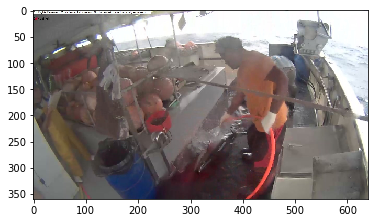

In [8]:
plot(trn[0])

In [10]:
test = get_data(DATA_DIR + 'test', (360,640))

Found 1000 images belonging to 1 classes.


In [11]:
save_array(MODEL_DIR + 'trn_640.dat', trn)
save_array(MODEL_DIR + 'val_640.dat', val)
save_array(MODEL_DIR + 'test_640.dat', test)

In [6]:
trn = load_array(MODEL_DIR + 'trn_640.dat')
val = load_array(MODEL_DIR + 'val_640.dat')
test = load_array(MODEL_DIR + 'test_640.dat')

In [8]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
print vgg640.input_shape, vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

(None, 3, 360, 640) (None, 512, 22, 40)


In [9]:
# pre compute convolutional features for large images
conv_val_feat = vgg640.predict(val, batch_size=32, verbose=1)
conv_trn_feat = vgg640.predict(trn, batch_size=32, verbose=1)

3393/3393 [==============================] - 436s     

In [47]:
conv_test_feat = vgg640.predict(test, batch_size=32, verbose=1)

1000/1000 [==============================] - 128s     

In [10]:
save_array(MODEL_DIR + 'conv_val_640.dat', conv_val_feat)
save_array(MODEL_DIR + 'conv_trn_640.dat', conv_trn_feat)

In [48]:
save_array(MODEL_DIR + 'conv_test_640.dat', conv_test_feat)

In [30]:
conv_val_feat = load_array(MODEL_DIR + 'conv_val_640.dat')
conv_trn_feat = load_array(MODEL_DIR + 'conv_trn_640.dat')

In [31]:
print conv_val_feat.shape
print conv_trn_feat.shape

(384, 512, 22, 40)
(3393, 512, 22, 40)


### Fully convolutional net

In [33]:
vgg640.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_input_2 (InputLayer)      (None, 3, 360, 640)   0                                            
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 3, 360, 640)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 362, 642)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 360, 640)  1792        zeropadding2d_14[0][0]           
___________________________________________________________________________________________

In [34]:
model = Sequential()
model.add(BatchNormalization(axis=1, input_shape=vgg640.model.layers[-1].output_shape[1:]))

model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D())

model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D())

model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D())

# prepare for output
model.add(Convolution2D(8,3,3, border_mode='same'))
model.add(GlobalAveragePooling2D())

# output
model.add(Activation('softmax'))

th


In [35]:
conv_trn_feat.shape

(3393, 512, 22, 40)

In [36]:
model.layers[0].input_shape

(None, 512, 22, 40)

In [38]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_13 (BatchNorma(None, 512, 22, 40)   1024        batchnormalization_input_4[0][0] 
____________________________________________________________________________________________________
convolution2d_39 (Convolution2D) (None, 128, 22, 40)   589952      batchnormalization_13[0][0]      
____________________________________________________________________________________________________
batchnormalization_14 (BatchNorma(None, 128, 22, 40)   256         convolution2d_39[0][0]           
____________________________________________________________________________________________________
maxpooling2d_20 (MaxPooling2D)   (None, 128, 11, 20)   0           batchnormalization_14[0][0]      
___________________________________________________________________________________________

In [39]:
lr = 0.001
model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
conv_feat = load_array(MODEL_DIR + 'conv_feat.dat')
conv_val_feat = load_array(MODEL_DIR + 'conv_val_feat.dat')

In [40]:
conv_val_feat.shape

(384, 512, 22, 40)

In [41]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(DIR)

Found 3393 images belonging to 8 classes.
Found 384 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


In [42]:
model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=1, 
             validation_data=(conv_val_feat, val_labels))

Train on 3393 samples, validate on 384 samples
Epoch 1/1
3393/3393 [==============================] - 15s - loss: 0.5628 - acc: 0.8229 - val_loss: 1.5455 - val_acc: 0.4740

In [43]:
# looking good, train more
model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, val_labels))

Train on 3393 samples, validate on 384 samples
Epoch 1/4
3393/3393 [==============================] - 15s - loss: 0.0728 - acc: 0.9797 - val_loss: 1.1785 - val_acc: 0.5755

In [44]:
# looking good, lower learning rate and train more
model.optimizer.lr = 1e-4
model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, val_labels))

Train on 3393 samples, validate on 384 samples
Epoch 1/4
3393/3393 [==============================] - 15s - loss: 0.1082 - acc: 0.9670 - val_loss: 0.7671 - val_acc: 0.7708

In [46]:
model.save_weights(MODEL_DIR + 'vgg-fully-conv-t9.h5')

## Create submission

In [10]:
test_batches = get_batches(DIR + 'test', batch_size=batch_size*2, class_mode=None, shuffle=False)

Found 12153 images belonging to 1 classes.


In [16]:
#model = vgg.model
#preds = model.predict_generator(test_batches, test_batches.nb_sample)

# pre-calculated convolutional features
model = vgg.model
preds = model.predict(conv_test_feat, batch_size=batch_size*2)
#preds = conv_model.predict(conv_test_feat, batch_size=batch_size*2)

Exception: Error when checking : expected lambda_input_1 to have shape (None, 3, 224, 224) but got array with shape (12153, 512, 14, 14)

In [12]:
preds.shape

(12153, 8)

In [13]:
# clip results
clip_max = 0.98
clip_min = 1 - clip_max
probs = np.clip(preds, clip_min, clip_max, out=None)

In [14]:
print probs.shape
print probs[:20]
print test_filenames[:5]

(12153, 8)
[[ 0.02    0.0748  0.02    0.02    0.02    0.02    0.9087  0.02  ]
 [ 0.02    0.02    0.02    0.02    0.02    0.02    0.98    0.02  ]
 [ 0.02    0.866   0.02    0.02    0.02    0.02    0.0341  0.0993]
 [ 0.02    0.98    0.02    0.02    0.02    0.02    0.02    0.02  ]
 [ 0.02    0.98    0.02    0.02    0.02    0.02    0.02    0.02  ]
 [ 0.02    0.02    0.02    0.02    0.98    0.02    0.02    0.02  ]
 [ 0.02    0.0743  0.02    0.02    0.02    0.02    0.02    0.921 ]
 [ 0.02    0.98    0.02    0.02    0.02    0.02    0.02    0.02  ]
 [ 0.02    0.98    0.02    0.02    0.02    0.02    0.02    0.02  ]
 [ 0.02    0.3965  0.02    0.02    0.02    0.02    0.6033  0.02  ]
 [ 0.02    0.98    0.02    0.02    0.02    0.02    0.02    0.02  ]
 [ 0.02    0.98    0.02    0.02    0.02    0.02    0.02    0.02  ]
 [ 0.02    0.0745  0.02    0.02    0.02    0.02    0.9231  0.02  ]
 [ 0.02    0.9375  0.02    0.02    0.02    0.02    0.02    0.0607]
 [ 0.02    0.0304  0.02    0.02    0.02    0.02    

In [16]:
df = pd.DataFrame(probs, columns=['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT'])
df.insert(0, 'image', [a[8:] for a in test_batches.filenames])
df.head()

image   ALB       BET   DOL   LAG   NoF  OTHER     SHARK      YFT
0  image_00001.jpg  0.02  0.074781  0.02  0.02  0.02   0.02  0.908675  0.02000
1  image_00002.jpg  0.02  0.020000  0.02  0.02  0.02   0.02  0.980000  0.02000
2  image_00003.jpg  0.02  0.866012  0.02  0.02  0.02   0.02  0.034117  0.09933
3  image_00004.jpg  0.02  0.980000  0.02  0.02  0.02   0.02  0.020000  0.02000
4  image_00005.jpg  0.02  0.980000  0.02  0.02  0.02   0.02  0.020000  0.02000

In [17]:
df.to_csv('fisheries-submission_stage2_001.csv', index=False)